In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
itachi9604_disease_symptom_description_dataset_path = kagglehub.dataset_download('itachi9604/disease-symptom-description-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'disease-symptom-description-dataset' dataset.
Data source import complete.


In [ ]:
import joblib

In [ ]:
%pip install seaborn

In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.svm import SVC
#from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report,plot_confusion_matrix,plot_roc_curve,precision_score,roc_curve
import seaborn as sns
from sklearn.utils import shuffle
#from pandas_profiling import ProfileReport
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

**Read and shuffle the dataset**

In [ ]:
df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')
df = shuffle(df,random_state=42)
df.head()

Disease        Symptom_1            Symptom_2  \
373                  Acne        skin_rash           blackheads   
4916                 Acne        skin_rash   pus_filled_pimples   
1550      Hyperthyroidism          fatigue          mood_swings   
3081                 AIDS   muscle_wasting    patches_in_throat   
3857  Chronic cholestasis          itching             vomiting   

            Symptom_3                Symptom_4          Symptom_5  \
373          scurring                      NaN                NaN   
4916       blackheads                 scurring                NaN   
1550      weight_loss             restlessness           sweating   
3081       high_fever   extra_marital_contacts                NaN   
3857   yellowish_skin                   nausea   loss_of_appetite   

            Symptom_6           Symptom_7          Symptom_8  \
373               NaN                 NaN                NaN   
4916              NaN                 NaN                NaN   
1550        diarrhoea     fast_heart_rate   excessive_hunger   
3081              NaN                 NaN                NaN   
3857   abdominal_pain   yellowing_of_eyes                NaN   

             Symptom_9     Symptom_10              Symptom_11 Symptom_12  \
373                NaN            NaN                     NaN        NaN   
4916               NaN            NaN                     NaN        NaN   
1550   muscle_weakness   irritability   abnormal_menstruation        NaN   
3081               NaN            NaN                     NaN        NaN   
3857               NaN            NaN                     NaN        NaN   

     Symptom_13 Symptom_14 Symptom_15 Symptom_16 Symptom_17  
373         NaN        NaN        NaN        NaN        NaN  
4916        NaN        NaN        NaN        NaN        NaN  
1550        NaN        NaN        NaN        NaN        NaN  
3081        NaN        NaN        NaN        NaN        NaN  
3857        NaN        NaN        NaN        NaN        NaN

**Removing Hyphen from strings**

In [ ]:
for col in df.columns:

    df[col] = df[col].str.replace('_',' ')
df.head()

Disease        Symptom_1            Symptom_2  \
373                  Acne        skin rash           blackheads   
4916                 Acne        skin rash   pus filled pimples   
1550      Hyperthyroidism          fatigue          mood swings   
3081                 AIDS   muscle wasting    patches in throat   
3857  Chronic cholestasis          itching             vomiting   

            Symptom_3                Symptom_4          Symptom_5  \
373          scurring                      NaN                NaN   
4916       blackheads                 scurring                NaN   
1550      weight loss             restlessness           sweating   
3081       high fever   extra marital contacts                NaN   
3857   yellowish skin                   nausea   loss of appetite   

            Symptom_6           Symptom_7          Symptom_8  \
373               NaN                 NaN                NaN   
4916              NaN                 NaN                NaN   
1550        diarrhoea     fast heart rate   excessive hunger   
3081              NaN                 NaN                NaN   
3857   abdominal pain   yellowing of eyes                NaN   

             Symptom_9     Symptom_10              Symptom_11 Symptom_12  \
373                NaN            NaN                     NaN        NaN   
4916               NaN            NaN                     NaN        NaN   
1550   muscle weakness   irritability   abnormal menstruation        NaN   
3081               NaN            NaN                     NaN        NaN   
3857               NaN            NaN                     NaN        NaN   

     Symptom_13 Symptom_14 Symptom_15 Symptom_16 Symptom_17  
373         NaN        NaN        NaN        NaN        NaN  
4916        NaN        NaN        NaN        NaN        NaN  
1550        NaN        NaN        NaN        NaN        NaN  
3081        NaN        NaN        NaN        NaN        NaN  
3857        NaN        NaN        NaN        NaN        NaN

**Dataset characteristics**

In [ ]:
df.describe()

Disease  Symptom_1  Symptom_2 Symptom_3    Symptom_4  Symptom_5  \
count     4920       4920       4920      4920         4572       3714   
unique      41         34         48        54           50         38   
top       Acne   vomiting   vomiting   fatigue   high fever   headache   
freq       120        822        870       726          378        348   

       Symptom_6        Symptom_7        Symptom_8           Symptom_9  \
count       2934             2268             1944                1692   
unique        32               26               21                  22   
top       nausea   abdominal pain   abdominal pain   yellowing of eyes   
freq         390              264              276                 228   

                Symptom_10     Symptom_11 Symptom_12         Symptom_13  \
count                 1512           1194        744                504   
unique                  21             18         11                  8   
top      yellowing of eyes   irritability    malaise   stomach bleeding   
freq                   198            120        126                 72   

         Symptom_14   Symptom_15      Symptom_16    Symptom_17  
count           306          240             192            72  
unique            4            3               3             1  
top      chest pain   chest pain   loss of smell   muscle pain  
freq             96          144              72            72

**Check for null and NaN values**

In [ ]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4     348
Symptom_5    1206
Symptom_6    1986
Symptom_7    2652
Symptom_8    2976
Symptom_9    3228
Symptom_10   3408
Symptom_11   3726
Symptom_12   4176
Symptom_13   4416
Symptom_14   4614
Symptom_15   4680
Symptom_16   4728
Symptom_17   4848


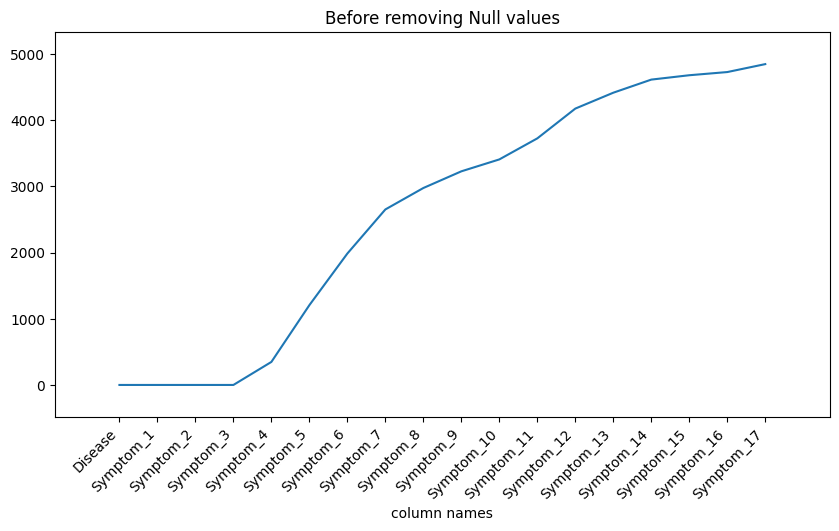

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('Before removing Null values')
plt.xlabel('column names')
plt.margins(0.1)
plt.show()

**Remove the trailing space from the symptom columns**

In [ ]:
cols = df.columns
data = df[cols].values.flatten()

s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)
df.head()

Disease       Symptom_1           Symptom_2       Symptom_3  \
0                 Acne       skin rash          blackheads        scurring   
1                 Acne       skin rash  pus filled pimples      blackheads   
2      Hyperthyroidism         fatigue         mood swings     weight loss   
3                 AIDS  muscle wasting   patches in throat      high fever   
4  Chronic cholestasis         itching            vomiting  yellowish skin   

                Symptom_4         Symptom_5       Symptom_6  \
0                     NaN               NaN             NaN   
1                scurring               NaN             NaN   
2            restlessness          sweating       diarrhoea   
3  extra marital contacts               NaN             NaN   
4                  nausea  loss of appetite  abdominal pain   

           Symptom_7         Symptom_8        Symptom_9    Symptom_10  \
0                NaN               NaN              NaN           NaN   
1                NaN               NaN              NaN           NaN   
2    fast heart rate  excessive hunger  muscle weakness  irritability   
3                NaN               NaN              NaN           NaN   
4  yellowing of eyes               NaN              NaN           NaN   

              Symptom_11 Symptom_12 Symptom_13 Symptom_14 Symptom_15  \
0                    NaN        NaN        NaN        NaN        NaN   
1                    NaN        NaN        NaN        NaN        NaN   
2  abnormal menstruation        NaN        NaN        NaN        NaN   
3                    NaN        NaN        NaN        NaN        NaN   
4                    NaN        NaN        NaN        NaN        NaN   

  Symptom_16 Symptom_17  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

**Fill the NaN values with zero**

In [ ]:
df = df.fillna(0)
df.head()

Disease       Symptom_1           Symptom_2       Symptom_3  \
0                 Acne       skin rash          blackheads        scurring   
1                 Acne       skin rash  pus filled pimples      blackheads   
2      Hyperthyroidism         fatigue         mood swings     weight loss   
3                 AIDS  muscle wasting   patches in throat      high fever   
4  Chronic cholestasis         itching            vomiting  yellowish skin   

                Symptom_4         Symptom_5       Symptom_6  \
0                       0                 0               0   
1                scurring                 0               0   
2            restlessness          sweating       diarrhoea   
3  extra marital contacts                 0               0   
4                  nausea  loss of appetite  abdominal pain   

           Symptom_7         Symptom_8        Symptom_9    Symptom_10  \
0                  0                 0                0             0   
1                  0                 0                0             0   
2    fast heart rate  excessive hunger  muscle weakness  irritability   
3                  0                 0                0             0   
4  yellowing of eyes                 0                0             0   

              Symptom_11 Symptom_12 Symptom_13 Symptom_14 Symptom_15  \
0                      0          0          0          0          0   
1                      0          0          0          0          0   
2  abnormal menstruation          0          0          0          0   
3                      0          0          0          0          0   
4                      0          0          0          0          0   

  Symptom_16 Symptom_17  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0

**Symptom severity rank**

In [ ]:
df1 = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/Symptom-severity.csv')
df1['Symptom'] = df1['Symptom'].str.replace('_',' ')
df1.head()

Symptom  weight
0               itching       1
1             skin rash       3
2  nodal skin eruptions       4
3   continuous sneezing       4
4             shivering       5

**Get overall list of symptoms**

In [ ]:
df1['Symptom'].unique()

array(['itching', 'skin rash', 'nodal skin eruptions',
       'continuous sneezing', 'shivering', 'chills', 'joint pain',
       'stomach pain', 'acidity', 'ulcers on tongue', 'muscle wasting',
       'vomiting', 'burning micturition', 'spotting urination', 'fatigue',
       'weight gain', 'anxiety', 'cold hands and feets', 'mood swings',
       'weight loss', 'restlessness', 'lethargy', 'patches in throat',
       'irregular sugar level', 'cough', 'high fever', 'sunken eyes',
       'breathlessness', 'sweating', 'dehydration', 'indigestion',
       'headache', 'yellowish skin', 'dark urine', 'nausea',
       'loss of appetite', 'pain behind the eyes', 'back pain',
       'constipation', 'abdominal pain', 'diarrhoea', 'mild fever',
       'yellow urine', 'yellowing of eyes', 'acute liver failure',
       'fluid overload', 'swelling of stomach', 'swelled lymph nodes',
       'malaise', 'blurred and distorted vision', 'phlegm',
       'throat irritation', 'redness of eyes', 'sinus pressu

**Encode symptoms in the data with the symptom rank**

In [ ]:
vals = df.values
symptoms = df1['Symptom'].unique()

for i in range(len(symptoms)):
    vals[vals == symptoms[i]] = df1[df1['Symptom'] == symptoms[i]]['weight'].values[0]

d = pd.DataFrame(vals, columns=cols)
d.head()

Disease Symptom_1 Symptom_2 Symptom_3 Symptom_4 Symptom_5  \
0                 Acne         3         2         2         0         0   
1                 Acne         3         2         2         2         0   
2      Hyperthyroidism         4         3         3         5         3   
3                 AIDS         3         6         7         5         0   
4  Chronic cholestasis         1         5         3         5         4   

  Symptom_6 Symptom_7 Symptom_8 Symptom_9 Symptom_10 Symptom_11 Symptom_12  \
0         0         0         0         0          0          0          0   
1         0         0         0         0          0          0          0   
2         6         5         4         2          2          6          0   
3         0         0         0         0          0          0          0   
4         4         4         0         0          0          0          0   

  Symptom_13 Symptom_14 Symptom_15 Symptom_16 Symptom_17  
0          0          0          0          0          0  
1          0          0          0          0          0  
2          0          0          0          0          0  
3          0          0          0          0          0  
4          0          0          0          0          0

**Assign symptoms with no rank to zero**

In [ ]:
d = d.replace('dischromic  patches', 0)
d = d.replace('spotting  urination',0)
df = d.replace('foul smell of urine',0)
df.head(10)

/tmp/ipython-input-969436745.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = d.replace('dischromic  patches', 0)
/tmp/ipython-input-969436745.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  d = d.replace('spotting  urination',0)
/tmp/ipython-input-969436745.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downc

Disease  Symptom_1  Symptom_2  Symptom_3  Symptom_4  Symptom_5  \
0                 Acne          3          2          2          0          0   
1                 Acne          3          2          2          2          0   
2      Hyperthyroidism          4          3          3          5          3   
3                 AIDS          3          6          7          5          0   
4  Chronic cholestasis          1          5          3          5          4   
5         Hypertension          3          7          4          4          3   
6         Hypoglycemia          5          4          4          3          3   
7            Arthritis          2          4          5          2          0   
8          Hepatitis B          1          4          2          3          4   
9             Migraine          3          5          3          5          4   

   Symptom_6  Symptom_7  Symptom_8  Symptom_9  Symptom_10  Symptom_11  \
0          0          0          0          0           0           0   
1          0          0          0          0           0           0   
2          6          5          4          2           2           6   
3          0          0          0          0           0           0   
4          4          4          0          0           0           0   
5          0          0          0          0           0           0   
6          5          5          4          4           4           2   
7          0          0          0          0           0           0   
8          4          4          4          4           6           5   
9          4          3          2          3           0           0   

   Symptom_12  Symptom_13  Symptom_14  Symptom_15  Symptom_16  Symptom_17  
0           0           0           0           0           0           0  
1           0           0           0           0           0           0  
2           0           0           0           0           0           0  
3           0           0           0           0           0           0  
4           0           0           0           0           0           0  
5           0           0           0           0           0           0  
6           4           0           0           0           0           0  
7           0           0           0           0           0           0  
8           2           0           0           0           0           0  
9           0           0           0           0           0           0

**Check if entire columns have zero values so we can drop those values**

In [ ]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4       0
Symptom_5       0
Symptom_6       0
Symptom_7       0
Symptom_8       0
Symptom_9       0
Symptom_10      0
Symptom_11      0
Symptom_12      0
Symptom_13      0
Symptom_14      0
Symptom_15      0
Symptom_16      0
Symptom_17      0


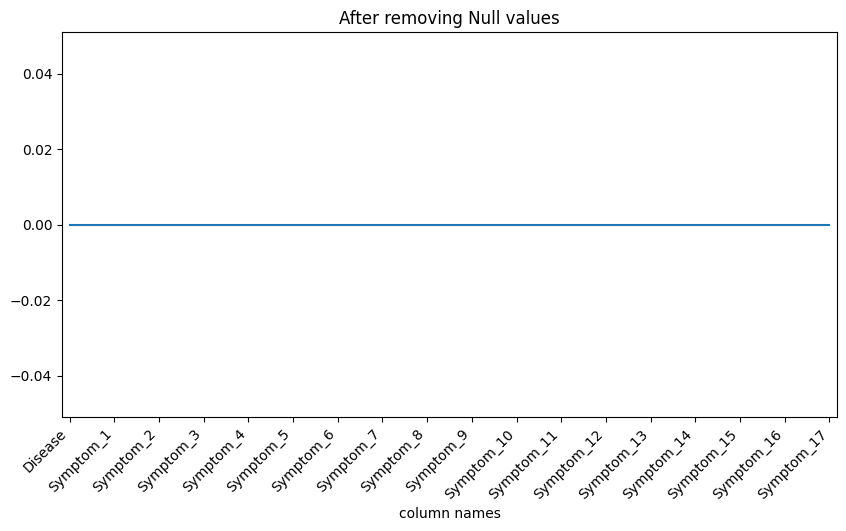

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('After removing Null values')
plt.xlabel('column names')
plt.margins(0.01)
plt.show()

In [ ]:
print("Number of symptoms used to identify the disease ",len(df1['Symptom'].unique()))
print("Number of diseases that can be identified ",len(df['Disease'].unique()))

Number of symptoms used to identify the disease  132
Number of diseases that can be identified  41


**Get the names of diseases from data**

In [ ]:
df['Disease'].unique()

array(['Acne', 'Hyperthyroidism', 'AIDS', 'Chronic cholestasis',
       'Hypertension', 'Hypoglycemia', 'Arthritis', 'Hepatitis B',
       'Migraine', 'Urinary tract infection', 'Diabetes', 'Hepatitis D',
       'Psoriasis', 'Alcoholic hepatitis', 'Dimorphic hemmorhoids(piles)',
       'Hepatitis E', 'Cervical spondylosis', 'Bronchial Asthma',
       'hepatitis A', 'Allergy', 'Hepatitis C', 'Pneumonia',
       'Hypothyroidism', 'Gastroenteritis', 'Varicose veins', 'Jaundice',
       'Drug Reaction', '(vertigo) Paroymsal  Positional Vertigo',
       'Heart attack', 'Tuberculosis', 'Typhoid', 'Common Cold',
       'Peptic ulcer diseae', 'Paralysis (brain hemorrhage)',
       'Fungal infection', 'Impetigo', 'GERD', 'Dengue', 'Malaria',
       'Chicken pox', 'Osteoarthristis'], dtype=object)

### Select the features as symptoms column and label as Disease column

Explination: A **feature** is an input; **label** is an output.
A feature is one column of the data in your input set. For instance, if you're trying to predict the type of pet someone will choose, your input features might include age, home region, family income, etc. The label is the final choice, such as dog, fish, iguana, rock, etc.

Once you've trained your model, you will give it sets of new input containing those features; it will return the predicted "label" (pet type) for that person.

In [ ]:
data = df.iloc[:,1:].values
labels = df['Disease'].values

## Splitting the dataset to training (80%) and testing (20%)

Separating data into training and testing sets is an important part of evaluating data mining models. Typically, when you separate a data set into a training set and testing set, most of the data is used for training, and a smaller portion of the data is used for testing. By using similar data for training and testing, you can minimize the effects of data discrepancies and better understand the characteristics of the model.
After a model has been processed by using the training set, we test the model by making predictions against the test set. Because the data in the testing set already contains known values for the attribute that you want to predict, it is easy to determine whether the model's guesses are correct.

* Train Dataset: Used to fit the machine learning model.
* Test Dataset: Used to evaluate the fit machine learning model.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8,random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(3936, 17) (984, 17) (3936,) (984,)


### Compute the F1 score, also known as balanced F-score or F-measure.

The F1 score can be interpreted as a weighted average of the precision and
recall, where an F1 score reaches its best value at 1 and worst score at 0.
The relative contribution of precision and recall to the F1 score are
equal. The formula for the F1 score is

    F1 = 2 * (precision * recall) / (precision + recall)

# Decision Tree

F1-score% = 95.7812664665753 | Accuracy% = 95.83333333333334


<Axes: >

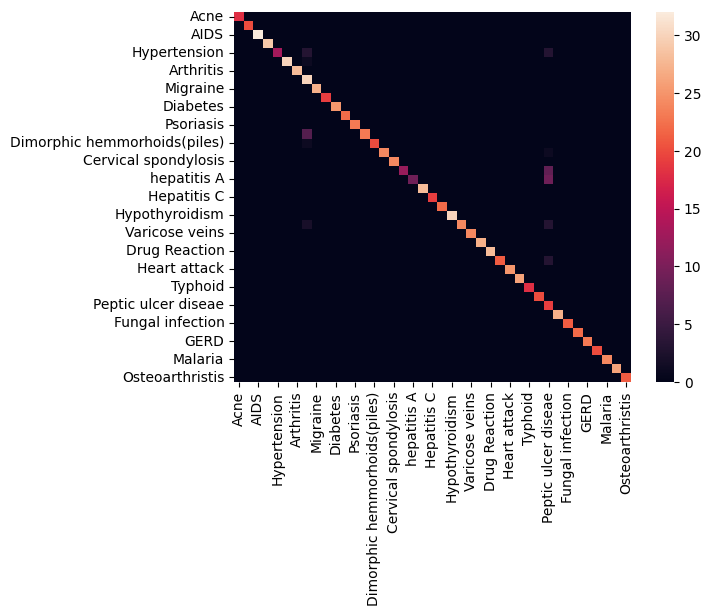

In [ ]:
tree =DecisionTreeClassifier(criterion='gini',random_state=42,max_depth=13)
tree.fit(x_train, y_train)
preds=tree.predict(x_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)

In [ ]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
DS_train =cross_val_score(tree, x_train, y_train, cv=kfold, scoring='accuracy')
pd.DataFrame(DS_train,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_train.mean()*100.0, DS_train.std()*100.0))

Mean Accuracy: 95.706%, Standard Deviation: (1.99%)


In [ ]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
DS_test =cross_val_score(tree, x_test, y_test, cv=kfold, scoring='accuracy')
pd.DataFrame(DS_test,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (DS_test.mean()*100.0, DS_test.std()*100.0))

Mean Accuracy: 94.198%, Standard Deviation: (3.57%)


# Random Forest

In [ ]:
rfc=RandomForestClassifier(random_state=42)

F1-score% = 99.58380389536958 | Accuracy% = 99.59349593495935


<Axes: >

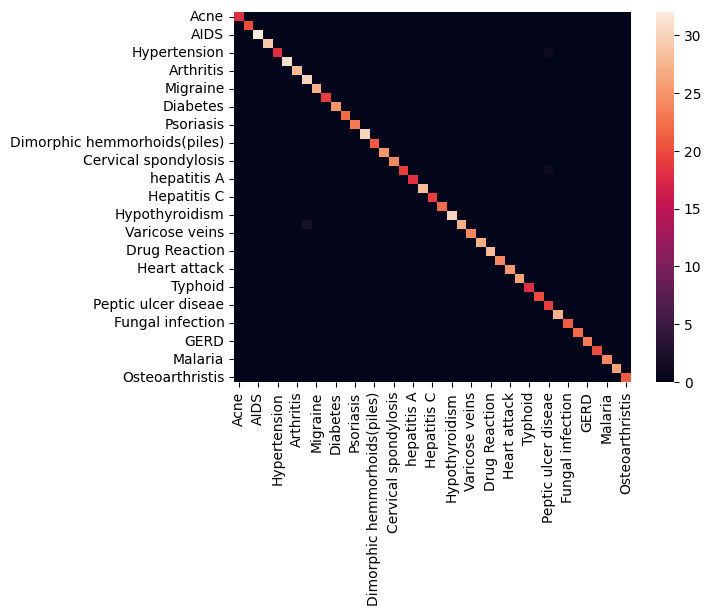

In [ ]:
rnd_forest = RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=13)
rnd_forest.fit(x_train,y_train)
preds=rnd_forest.predict(x_test)
conf_mat = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(conf_mat, index=df['Disease'].unique(), columns=df['Disease'].unique())
print('F1-score% =', f1_score(y_test, preds, average='macro')*100, '|', 'Accuracy% =', accuracy_score(y_test, preds)*100)
sns.heatmap(df_cm)

In [ ]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
rnd_forest_train =cross_val_score(rnd_forest, x_train, y_train, cv=kfold, scoring='accuracy')
pd.DataFrame(rnd_forest_train,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_train.mean()*100.0, rnd_forest_train.std()*100.0))

Mean Accuracy: 99.187%, Standard Deviation: (0.44%)


In [ ]:
kfold = KFold(n_splits=10,shuffle=True,random_state=42)
rnd_forest_test =cross_val_score(rnd_forest, x_test, y_test, cv=kfold, scoring='accuracy')
pd.DataFrame(rnd_forest_test,columns=['Scores'])
print("Mean Accuracy: %.3f%%, Standard Deviation: (%.2f%%)" % (rnd_forest_test.mean()*100.0, rnd_forest_test.std()*100.0))

Mean Accuracy: 98.575%, Standard Deviation: (1.31%)


# Fucntion to manually test the models

In [ ]:
discrp = pd.read_csv("/kaggle/input/disease-symptom-description-dataset/symptom_Description.csv")

In [ ]:
discrp.head()

Disease                                        Description
0   Drug Reaction  An adverse drug reaction (ADR) is an injury ca...
1         Malaria  An infectious disease caused by protozoan para...
2         Allergy  An allergy is an immune system response to a f...
3  Hypothyroidism  Hypothyroidism, also called underactive thyroi...
4       Psoriasis  Psoriasis is a common skin disorder that forms...

In [ ]:
ektra7at = pd.read_csv("/kaggle/input/disease-symptom-description-dataset/symptom_precaution.csv")

In [ ]:
ektra7at.head()

Disease                      Precaution_1  \
0   Drug Reaction                   stop irritation   
1         Malaria          Consult nearest hospital   
2         Allergy                    apply calamine   
3  Hypothyroidism                     reduce stress   
4       Psoriasis  wash hands with warm soapy water   

                   Precaution_2        Precaution_3  \
0      consult nearest hospital    stop taking drug   
1               avoid oily food  avoid non veg food   
2       cover area with bandage                 NaN   
3                      exercise         eat healthy   
4  stop bleeding using pressure      consult doctor   

                  Precaution_4  
0                    follow up  
1           keep mosquitos out  
2  use ice to compress itching  
3             get proper sleep  
4                   salt baths

**Save Random Forest model**

In [ ]:
# save
#joblib.dump(rfc, "/kaggle/working/random_forest.joblib")

**Load Model**

In [ ]:
# load, no need to initialize the loaded_rf
#loaded_rf = joblib.load("/kaggle/working/random_forest.joblib")

In [ ]:
def predd(x,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17):
    psymptoms = [S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,S17]
    #print(psymptoms)
    a = np.array(df1["Symptom"])
    b = np.array(df1["weight"])
    for j in range(len(psymptoms)):
        for k in range(len(a)):
            if psymptoms[j]==a[k]:
                psymptoms[j]=b[k]
    psy = [psymptoms]
    pred2 = x.predict(psy)
    disp= discrp[discrp['Disease']==pred2[0]]
    disp = disp.values[0][1]
    recomnd = ektra7at[ektra7at['Disease']==pred2[0]]
    c=np.where(ektra7at['Disease']==pred2[0])[0][0]
    precuation_list=[]
    for i in range(1,len(ektra7at.iloc[c])):
          precuation_list.append(ektra7at.iloc[c,i])
    print("The Disease Name: ",pred2[0])
    print("The Disease Discription: ",disp)
    print("Recommended Things to do at home: ")
    for i in precuation_list:
        print(i)

# Comparison between algorithms testing and training

In [ ]:
n_groups = 2
algorithms = ('Decision Tree', 'Random Forest')
train_accuracy = (DS_train.mean()*100.0,
                 rnd_forest_train.mean()*100.0,)

In [ ]:
test_accuracy = (DS_test.mean()*100.0,
                 rnd_forest_test.mean()*100.0)

In [ ]:
Standard_Deviation=(DS_test.std()*100.0,
                 rnd_forest_test.std()*100.0)

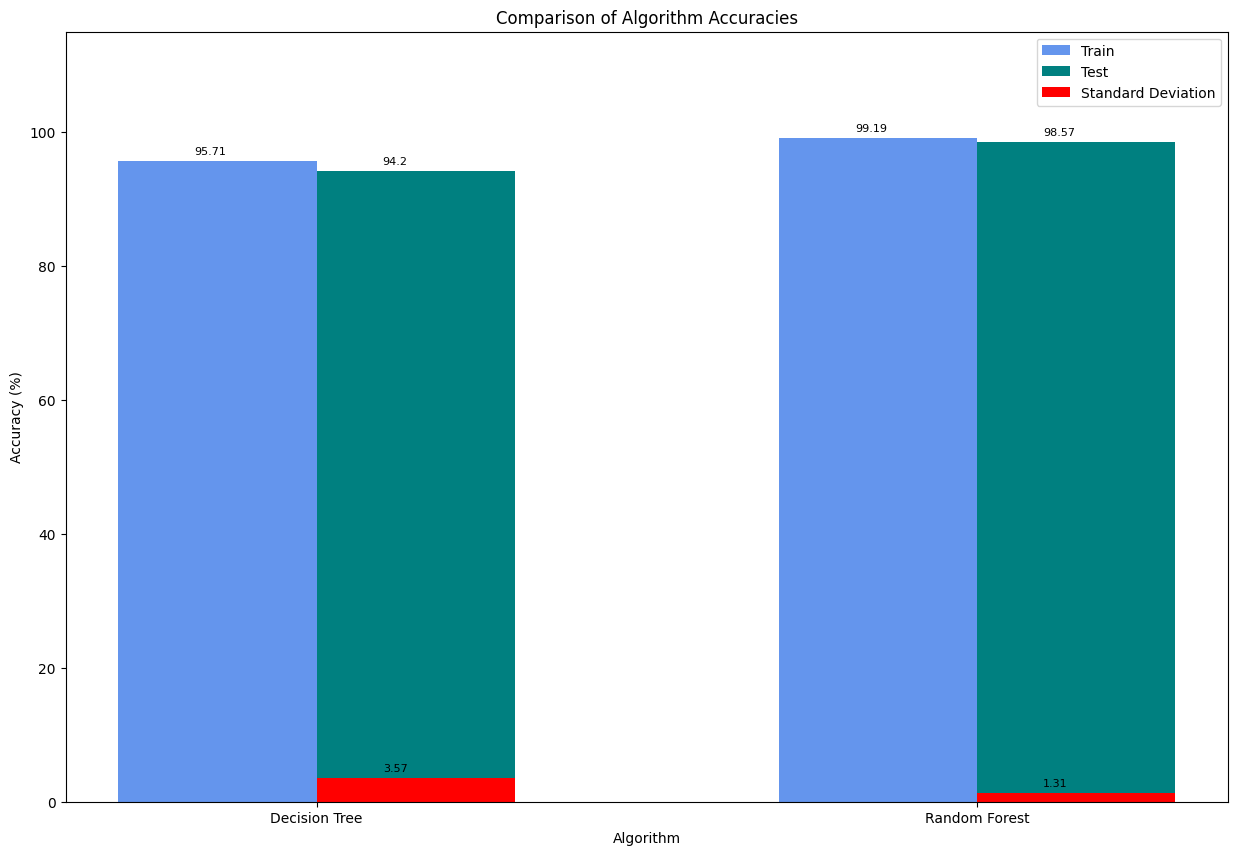

In [ ]:
# create plot
fig, ax = plt.subplots(figsize=(15, 10))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1
rects1 = plt.bar(index, train_accuracy, bar_width, alpha = opacity, color='Cornflowerblue', label='Train')
rects2 = plt.bar(index + bar_width, test_accuracy, bar_width, alpha = opacity, color='Teal', label='Test')
rects3 = plt.bar(index + bar_width, Standard_Deviation, bar_width, alpha = opacity, color='red', label='Standard Deviation')
plt.xlabel('Algorithm') # x axis label
plt.ylabel('Accuracy (%)') # y axis label
plt.ylim(0, 115)
plt.title('Comparison of Algorithm Accuracies') # plot title
plt.xticks(index + bar_width * 0.5, algorithms) # x axis data labels
plt.legend(loc = 'upper right') # show legend
for index, data in enumerate(train_accuracy):
    plt.text(x = index - 0.035, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
for index, data in enumerate(test_accuracy):
    plt.text(x = index + 0.25, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))
for index, data in enumerate(Standard_Deviation):
    plt.text(x = index + 0.25, y = data + 1, s = round(data, 2), fontdict = dict(fontsize = 8))

**Test it Like The user would do**

In [ ]:
sympList=df1["Symptom"].to_list()
predd(rnd_forest,sympList[7],sympList[5],sympList[2],sympList[80],0,0,0,0,0,0,0,0,0,0,0,0,0)

The Disease Name:  Paralysis (brain hemorrhage)
The Disease Discription:  Intracerebral hemorrhage (ICH) is when blood suddenly bursts into brain tissue, causing damage to your brain. Symptoms usually appear suddenly during ICH. They include headache, weakness, confusion, and paralysis, particularly on one side of your body.
Recommended Things to do at home: 
massage
eat healthy
exercise
consult doctor
